# <span style="color:#336699">SER-347 - Trabalho final</span>

<hr style="border:2px solid #0077b9;">

# <span style="color:#336699">Detecção de alvos artificiais em ambientes marítimos por meio de imagens SAR</span>

- Leonan Entringer Falqueto
- Billy Edy Mendes

<hr style="border:0.5px solid #0077b9;">

## <span style="color:#336699">Objetivo:<span>
   <hr style="border:0.5px solid #0077b9;">
   
   Pretende-se estruturar um programa, utilizando a linguagem python, para aplicar a técnica de _threshold_ e identificar objetos artificiais em ambiente marítimo.
   


## <span style="color:#336699">__Primeira fase__: abrir a imagem SAR.<span>

__Desafio__: identificar a codificação do arquivo (configurações e metadados) para abrir a imagem com Python.
<hr style="border:0.5px solid #0077b9;">
Foram utilizadas imagens _full polarimétricas_ do Satélite ALOS PALSAR já com um nível de processamento 
(Compressão de pulsos em _range_ e azimute, L-1.1) e a biblioteca GDAL para ler as bandas.

In [5]:
# importar bibliotecas e constantes
from osgeo import gdal
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math 
import cmath
import os
import glob
import sys

# importar constantes
from gdalconst import *

# informar o uso de exceções
gdal.UseExceptions()

# mostrar versão instalada
print ("Para esse programa, foram usadas as seguintes versões de bibliotecas, da Anaconda e do python:",
       "\n","Gdal 2.2.2, Matplotlib 2.1.2, Numpy 1.14.2, Conda 4.5.4 e Python 3.6.4", "\n\n",
      "Confira suas versões instaladas:")
print ("Gdal", gdal.__version__)
print ("Matplotlib", matplotlib.__version__)
print ("Numpy", np.__version__)
!conda --version
!python --version

Para esse programa, foram usadas as seguintes versões de bibliotecas, da Anaconda e do python: 
 Gdal 2.2.2, Matplotlib 2.1.2, Numpy 1.14.2, Conda 4.5.4 e Python 3.6.4 

 Confira suas versões instaladas:
Gdal 2.2.2
Matplotlib 2.1.2
Numpy 1.14.2
conda 4.5.4


Python 3.6.5 :: Anaconda, Inc.


### Ler a imagem:

In [6]:
# Criar o dataset abrindo o arquivo para leitura
# o 'r' antes do caminho serve para entender a string raw para não ter problemas com a \ (caracter especial).

filename = r"C:\SAR_data\ALPSRP173876680-L1.1-Merluza\ALPSRP173876680-L1.1\VOL-ALPSRP173876680-P1.1__A"

try:
    dataset = gdal.Open(filename, GA_ReadOnly)
    print ("Arquivo aberto com sucesso")
except:
    print("Erro na abertura do arquivo")

dataset = gdal.Open(filename, GA_ReadOnly)
if not dataset:
    ...

Arquivo aberto com sucesso


### Obter os metadados e extrair as bandas:

In [7]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                             dataset.GetDriver().LongName))
print("Size is {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize))
metadados = dataset.GetMetadata()
print(metadados)

def Statistic_raster(banda):
    st = banda.GetStatistics(False,True)
    print("Min=%.2f, Max=%.2f, Mean=%.2f, Std=%.2f" % (st[0], st[1], st[2], st[3] ))
    return None

polarizacoes = ["HH", "HV", "VH", "VV"]
bandas = dataset.RasterCount
if bandas == 4:
    print("É um arquivo full pol")
    for i in range(bandas):
        banda = dataset.GetRasterBand(i + 1)
        print(" Band {} Type={}".format(banda.GetMetadata_Dict()["POLARIMETRIC_INTERP"] ,
                                        gdal.GetDataTypeName(banda.DataType)))
        Statistic_raster(banda)
        
        print()
        polarizacoes[i] = banda
else:
    print("A imagem possui outro tipo de polarização ou não é possível fazer sua leitura")

Driver: JAXAPALSAR/JAXA PALSAR Product Reader (Level 1.1/1.5)
Size is 1088 x 18432
{'AZIMUTH_LOOKS': '1.0', 'MATRIX_REPRESENTATION': 'SCATTERING', 'PRODUCT_LEVEL': '1.1', 'RANGE_LOOKS': '1.0', 'SENSOR_BAND': 'L'}
É um arquivo full pol
 Band HH Type=CFloat32
Min=-83262201948768231105009302959655223296.00, Max=1104057.62, Mean=-9147973030081118484015335079936.00, Std=26532647636097598526778504663531520.00

 Band HV Type=CFloat32
Min=-83262201948768231105009302959655223296.00, Max=292324.38, Mean=-9147973030081118484015335079936.00, Std=26532647636097598526778504663531520.00

 Band VH Type=CFloat32
Min=-83262201948768231105009302959655223296.00, Max=308012.03, Mean=-9147973030081118484015335079936.00, Std=26532647636097598526778504663531520.00

 Band VV Type=CFloat32
Min=-83262201948768231105009302959655223296.00, Max=969648.44, Mean=-9147973030081118484015335079936.00, Std=26532647636097598526778504663531520.00



### Exemplos de metadados através do arquivo Workreport

Arquivo descritivo da imagem do ALOS-PALSAR

In [8]:
path = r'C:\SAR_data\ALPSRP173876680-L1.1-Merluza\ALPSRP173876680-L1.1\\'
os.chdir(path)
file = path + glob.glob('work*')[0]

f = open(file)
data = f.read(2000)
metadata = data.splitlines()
print("ID = {}\nSamples = {}\nLines = {}\nImageSceneCenterLatitude = {}\nImageSceneCenterLongitude = {}\n"
      .format(metadata[2].split("=")[1], metadata[18].split("=")[1], metadata[19].split("=")[1], 
              metadata[30].split("=")[1], metadata[31].split("=")[1]))

ID = "ALPSRP173876680"
Samples = "1088"
Lines = "18432"
ImageSceneCenterLatitude = "-25.238"
ImageSceneCenterLongitude = "-45.245"



### Ler as bandas como objeto Numpy Array:

In [13]:
#Transformar as bandas em um objeto numpy (Uma array)
array_HH = polarizacoes[0].ReadAsArray()
array_HV = polarizacoes[1].ReadAsArray()
array_VH = polarizacoes[2].ReadAsArray()
array_VV = polarizacoes[3].ReadAsArray()
dataset = None

#Ler a primeira linha da banda HH:
#A primeira linha de fato parece ser uma borda, por isso, foi utilizado indíce [1]
print("Primeira linha da banda HH:",'\n', array_HH[1],'\n')
# print("Primeira linha da banda HV:",'\n', array_HV[1],'\n')
# print("Primeira linha da banda VH:",'\n', array_VH[1],'\n')
# print("Primeira linha da banda VV:",'\n', array_VV[1],'\n')

#Obter a amplitude e fase do primeiro pixel de cada banda:
print("O primeiro pixel da banda HH possui:", "\n", 
      'Amplitude:{} e fase: {} rad'.format(cmath.polar(array_HH[1][0])[0], cmath.polar(array_HH[1][0])[1]),'\n')
# print("O primeiro pixel da banda HV possui:", "\n",
#          'Amplitude:{} e fase: {} rad'.format(cmath.polar(array_HV[1][0])[0], cmath.polar(array_HV[1][0])[1]),'\n')
# print("O primeiro pixel da banda VH possui:", "\n",
#          'Amplitude:{} e fase: {} rad'.format(cmath.polar(array_VH[1][0])[0], cmath.polar(array_VH[1][0])[1]),'\n')
# print("O primeiro pixel da banda VV possui:", "\n",
#         'Amplitude:{} e fase: {} rad'.format(cmath.polar(array_VV[1][0])[0], cmath.polar(array_VV[1][0])[1]),'\n')
polarizacoes = None       


Primeira linha da banda HH: 
 [ 18472.672 +34914.527j   3783.201 -24045.592j -34928.996  +6424.966j ...
 -24770.018 -25555.605j -14530.691 -18680.244j  -1914.7942-40838.46j ] 

O primeiro pixel da banda HH possui: 
 Amplitude:39500.17501023106 e fase: 1.0841541678374862 rad 



### Criar subset das bandas:

In [15]:
#Extrair subsets das arrays numpy
subset_HH = array_HH[7900:8600,300:650]
array_HH = None
# print(subset_HH.shape)
# print(subset_HH)

subset_HV = array_HV[7900:8600,300:650]
array_HV = None
# print(subset_HV.shape)
# print(subset_HV)

subset_VH = array_VH[7900:8600,300:650]
array_VH = None
# print(subset_VH.shape)
# print(subset_VH)

subset_VV = array_VV[7900:8600,300:650]
array_VV = None
# print(subset_VV.shape)
# print(subset_VV)

TypeError: 'NoneType' object is not subscriptable

<hr style="border:1px solid #0077b9;">

## <span style="color:#336699"> __Segunda fase__: aplicar um filtro para suavizar o efeito _Speckle_ típico de imagens SAR.<span>

__Desafio__: construir uma janela de convolução para aplicar a fórmula do filtro escolhido.

<hr style="border:0.5px solid #0077b9;">

## Pré-processamento: imagem amplitude e calibração


In [20]:
#Algumas funções básicas de pré-processamento da imagem SAR:

def array_amplitude(array):
    """
    Extrai a informação de amplitude de uma imagem complexa. 
    array: ndarray object (datatype complex)
    """
    [lines, samples] = array.shape
    img_amplitude = []
    for i in range(lines):
        for j in range(samples):
            pixel = cmath.polar(array[i][j])[0]
            pixel = float(pixel)
            img_amplitude.append(pixel) 
    array_amplitude = np.array(img_amplitude).reshape(lines, samples)
    print("process finished")
    return array_amplitude

def intensity_from_array(array):
    """
    Extrai a informação de intensidade de uma imagem complexa. 
    array: ndarray object (datatype complex)
    """
    [lines, samples] = array.shape
    img_amplitude = []
    for i in range(lines):
        for j in range(samples):
            pixel = cmath.polar(array[i][j])[0]
            pixel = float(pixel)
            img_amplitude.append(pixel) 
    array_amplitude = np.array(img_amplitude).reshape(lines, samples)
    array_intensity = array_amplitude**2
    print("process finished")
    return array_intensity

def calibration_from_array(array):
    """
    Extrai a informação de amplitude de uma imagem complexa
    e calibra conforme parâmetros para imagem full pol do
    Satélite ALOS-PALSAR
    array: ndarray object (datatype complex)
    """
    [lines, samples] = array.shape
    img_cal = []
    for i in range(lines):
        for j in range(samples):
            pixel = cmath.polar(array[i][j])[0]
            if not pixel:  # dirty patch to avoid zero division
                pixel_cal = -250.0
            else:
                pixel = float(pixel)
                pixel_cal = (math.log10(pixel)*20)-83.4
            img_cal.append(pixel_cal) 
    array_AmpCal = np.array(img_cal).reshape(lines, samples)
    print("calibration finished")
    return array_AmpCal

def normalize(array, bits=256):
    """
    Normaliza uma array para x bytes  (Standart : 256)
    array: ndarray object (datatype complex)
    """
    # Min e max from array
    min_array = array.min()
    max_array = array.max()
    # Range in bits
    min_normal = 0
    max_normal = bits
    #Normalize factor:
    gain = (max_normal/(max_array-min_array))
    offset = array-min_array
    array_normalized = (gain*offset)
    print("normalize process finished")
    return array_normalized

def InPhaseAndQuadrature(array):
    """
    Extrai a array in-phase e quadrature de uma banda.
    array: ndarray object (datatype complex)
    """
    array_real = np.real(array)
    array_imag = np.imag(array)
    return array_real, array_imag
    
def histogram_sar(array, line=0, bins=64, facecolor = "red"):
    """
    Plota o histograma de uma linha de um array
    array: ndarray object (datatype complex)
    line: int. Linha de interesse
    bins: int. quantidade de níveis
    facecolor: str. Cor da barra
    
    """
    plt.hist(array[line], bins=bins, density=False, align='left',
         facecolor=facecolor, edgecolor="black", linewidth=0.5, alpha=0.65)
    plt.ylabel("Frequency")

In [21]:
#Obter a imagem amplitude, a calibração e normalizar para 256Bits:
subsetHV_Amp = array_amplitude(subset_HV)
subsetHV_Sigma0=calibration_from_array(subset_HV)
subsetHV_Sigma0Norm = normalize(subsetHV_Sigma0)

process finished
calibration finished
normalize process finished


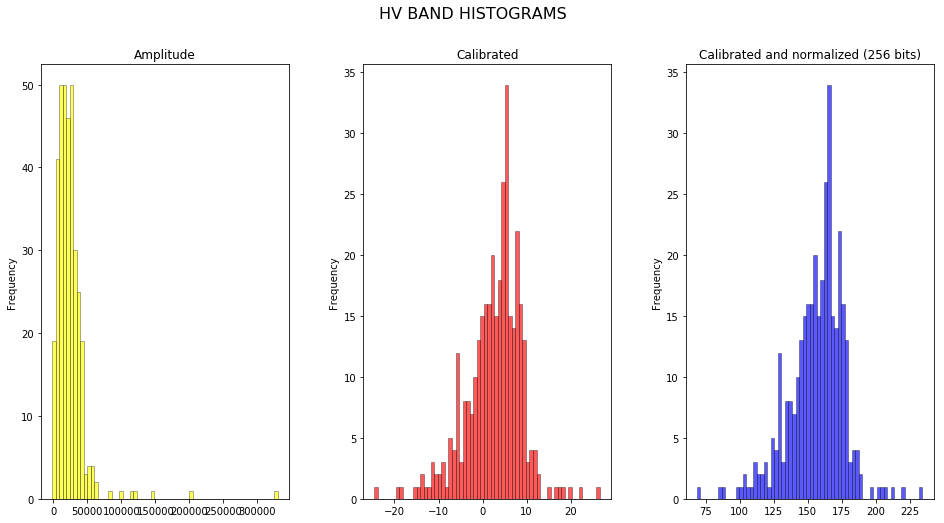

In [28]:
#Plotar o histograma da linha 545 para cada processamento realizado
plt.figure( figsize=(16, 8) )
plt.suptitle("HV BAND HISTOGRAMS",fontsize = 16)
plt.subplots_adjust(wspace=0.3)

plt.subplot(131)
histogram_sar(subsetHV_Amp, line=545, facecolor="yellow")
plt.title("Amplitude")

plt.subplot(132)
histogram_sar(subsetHV_Sigma0, line=545)
plt.title("Calibrated")

plt.subplot(133)
histogram_sar(subsetHV_Sigma0Norm, line=545, facecolor="blue")
plt.title("Calibrated and normalized (256 bits)");

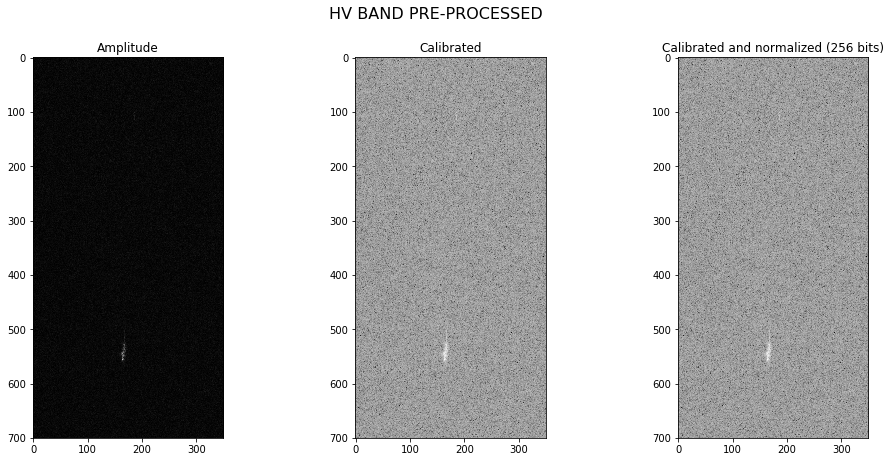

In [29]:
#mostrar as pré-processadas:
plt.figure( figsize=(16, 7) )
plt.subplots_adjust(wspace=0.3)
plt.suptitle("HV BAND PRE-PROCESSED", fontsize = 16)

plt.subplot(131)
plt.imshow(subsetHV_Amp, cmap='gray')
plt.title("Amplitude")
plt.suptitle

plt.subplot(132)
plt.imshow(subsetHV_Sigma0, cmap='gray')
plt.title("Calibrated")

plt.subplot(133)
plt.imshow(subsetHV_Sigma0Norm, cmap='gray')
plt.title( "Calibrated and normalized (256 bits)")
          
plt.show()

## Filtragem:

In [31]:
#!/usr/bin/env python
    # -*- coding: utf-8 -*-

    # Copyright 2012 - 2013
    # Matías Herranz <matiasherranz@gmail.com>
    # Joaquín Tita <joaquintita@gmail.com>
    #
    # https://github.com/PyRadar/pyradar
    #
    # This library is free software; you can redistribute it and/or
    # modify it under the terms of the GNU Lesser General Public
    # License as published by the Free Software Foundation; either
    # version 3 of the License, or (at your option) any later version.
    #
    # This library is distributed in the hope that it will be useful,
    # but WITHOUT ANY WARRANTY; without even the implied warranty of
    # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
    # Lesser General Public License for more details.
    #
    # You should have received a copy of the GNU Lesser General Public
    # License along with this library. If not, see <http://www.gnu.org/licenses/>.

COEF_VAR_DEFAULT = 0.01
CU_DEFAULT = 0.25


def weighting(window, cu=CU_DEFAULT):
    """
    Computes the weighthing function for Lee filter using cu as the noise
    coefficient.
    """
    # cu is the noise variation coefficient
    two_cu = cu * cu

    # ci is the variation coefficient in the window
    window_mean = window.mean()
    window_std = window.std()
    ci = window_std / window_mean

    two_ci = ci * ci

    if not two_ci:  # dirty patch to avoid zero division
        two_ci = COEF_VAR_DEFAULT

    if cu > ci:
        w_t = 0.0
    else:
        w_t = 1.0 - (two_cu / two_ci)

    return w_t

def assert_window_size(win_size):
    """
    Asserts invalid window size.
    Window size must be odd and bigger than 3.
    """
    assert win_size >= 3, 'ERROR: win size must be at least 3'

    if win_size % 2 == 0:
        print ('It is highly recommended to user odd window sizes.' , '\n','You provided %s, an even number.' % (win_size) )

def assert_indices_in_range(width, height, xleft, xright, yup, ydown):
    """
    Asserts index out of image range.
    """
    assert xleft >= 0 and xleft <= width, \
        "index xleft:%s out of range (%s<= xleft < %s)" % (xleft, 0, width)

    assert xright >= 0 and xright <= width, \
        "index xright:%s out of range (%s<= xright < %s)" % (xright, 0, width)

    assert yup >= 0 and yup <= height, \
        "index yup:%s out of range. (%s<= yup < %s)" % (yup, 0, height)

    assert ydown >= 0 and ydown <= height, \
        "index ydown:%s out of range. (%s<= ydown < %s)" % (ydown, 0, height)

def lee_filter(img, win_size=3, cu=CU_DEFAULT):
    """
    Apply lee to a numpy matrix containing the image, with a window of
    win_size x win_size.
    """
    assert_window_size(win_size)

    # we process the entire img as float64 to avoid type overflow error
    img = np.float64(img)
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = round(win_size / 2)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            pix_value = img[i, j]
            window = img[xleft:xright, yup:ydown]
            w_t = weighting(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))

            img_filtered[i, j] = round(new_pix_value)
    print("filtered")
    return img_filtered

In [32]:
def mean_filter(img, win_size=3):
    """
    Apply a 'mean filter' to 'img' with a window size equal to 'win_size'.
    Parameters:
        - img: a numpy matrix representing the image.
        - win_size: the size of the windows (by default 3).
    """
    assert win_size >= 3, 'ERROR: win size must be at least 3'

    if win_size % 2 == 0:
        print ('It is highly recommended to user odd window sizes.' , '\n','You provided %s, an even number.' % (win_size) )

    N, M = img.shape
    win_offset = round(win_size / 2)
    img_filtered = np.zeros_like(img)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M
                
            window = img[xleft:xright, yup:ydown]
            window_mean = window.mean()

            img_filtered[i, j] = round(window_mean)
    print("filtered")
    return img_filtered

### Comparação entre os filtros de média e Lee:

In [33]:
#Comparação entre filtros:
subsetHV_SigmaMean = mean_filter(subsetHV_Sigma0)
subsetHV_SigmaLee = lee_filter(subsetHV_Sigma0)

filtered
filtered


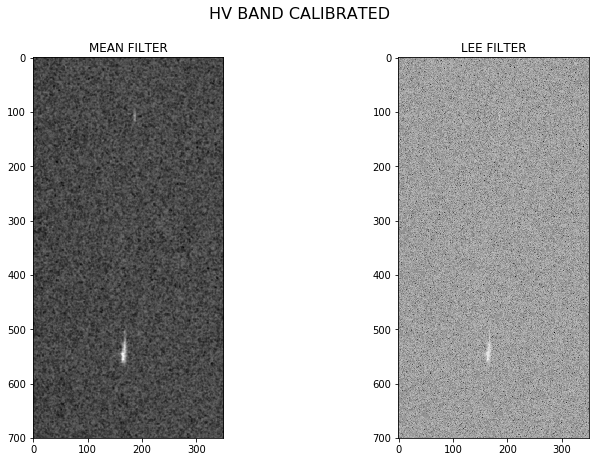

In [34]:
#mostrar as imagens com filtros diferentes:
plt.figure( figsize=(12, 7) )

plt.suptitle("HV BAND CALIBRATED", fontsize = 16)

plt.subplot(121)
plt.imshow(subsetHV_SigmaMean, cmap='gray')
plt.title("MEAN FILTER")

plt.subplot(122)
plt.imshow(subsetHV_SigmaLee, cmap='gray')
plt.title("LEE FILTER")

plt.show()

### Comparação entre tamanhos diferentes de janela para filtragem:

In [35]:
# Filtragem com tamanhos de janelas diferentes:
subsetHV_SigmaMean_win3 = mean_filter(subsetHV_Sigma0)
subsetHV_SigmaMean_win15 = mean_filter(subsetHV_Sigma0, win_size=15)
subsetHV_SigmaMean_win45 = mean_filter(subsetHV_Sigma0, win_size=45)

filtered
filtered
filtered


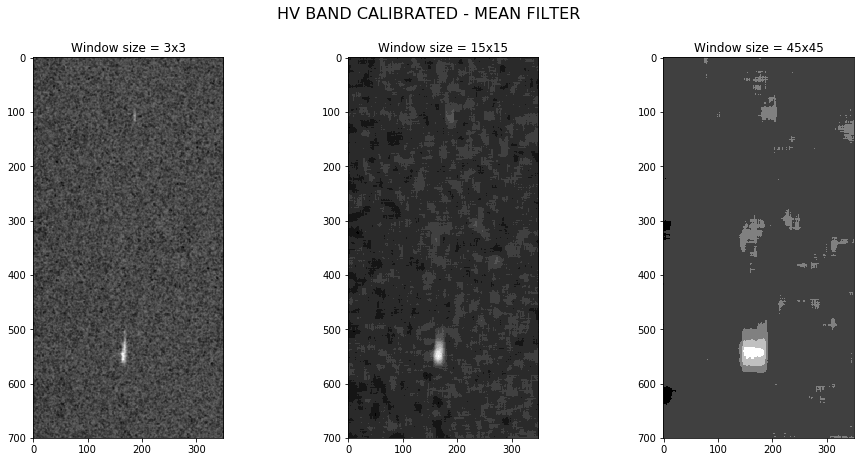

In [36]:
#mostrar as imagens de janelamentos diferentes:
plt.figure( figsize=(16, 7 ))

plt.suptitle("HV BAND CALIBRATED - MEAN FILTER", fontsize = 16)

plt.subplot(131)
plt.imshow(subsetHV_SigmaMean_win3, cmap='gray')
plt.title("Window size = 3x3")

plt.subplot(132)
plt.imshow(subsetHV_SigmaMean_win15, cmap='gray')
plt.title("Window size = 15x15")

plt.subplot(133)
plt.imshow(subsetHV_SigmaMean_win45, cmap='gray')
plt.title("Window size = 45x45")

plt.show()

<hr style="border:1px solid #0077b9;">

## <span style="color:#336699"> __Terceira fase__: Calcular o parâmetro escolhido

__Desafio__: utilizar um parâmetro que utiliza dados de mais de uma banda

Parâmetro escolhido: decomposição de Pauli

<hr style="border:0.5px solid #0077b9;">

### Pauli decomposition:
"The objective of the coherent decompositions is to express the measured scattering matrix by the radar, i.e., [S] as the combination of the scattering responses of simpler objects:
$$[S] = \sum_{\substack{i=1}}^{j}c_i[S]_i $$

...

Given a measured scattering matrix, it can be decomposed as follows:
$$[S] = \left[ \begin{array}{cc}
S_{hh} & S_{hv} \\ 
S_{vh} & S_{vv}
\end{array} \right] = \alpha [S]_a + \beta [S]_b + \gamma [S]_c$$

where:

$$\alpha = \frac{S_{hh} + S_{vv}} {\sqrt{2}}$$

$$\beta = \frac{S_{hh} - S_{vv}} {\sqrt{2}}$$

$$\gamma = \sqrt{2}S_{hv}$$

...

The the span of [S] can be obtained as can be obtained as:

$$SPAN = |S_{hh}|^2 + |S_{vv}|^2 + 2|S_{hv}|^2 = |\alpha|^2 + |\beta|^2 + |\gamma|^2$$

...

"$\beta$ stands for the complex coefficient of this scattering mechanism and $\beta^2$ represents the scattered power by this type of targets".[7]

In [37]:
#Pauli decomposition:
#Intensity power of scattering mechanisms:
def Pauli_alpha(array_HH, array_VV):
    alpha = (array_HH + array_VV) * (1/math.sqrt(2))
    alpha_sigma = calibration_from_array(alpha)
    if array_HH.shape == alpha_sigma.shape:
            print("Decomposed alpha")
    return alpha_sigma

def Pauli_beta(array_HH, array_VV):
    beta = (array_HH - array_VV) * (1/math.sqrt(2))
    beta_sigma = calibration_from_array(beta)
    if array_HH.shape == beta_sigma.shape:
            print("Decomposed beta")
    return beta_sigma

def Pauli_gamma(array_HV):
    gamma = (array_HV) * math.sqrt(2)
    gamma_sigma = calibration_from_array(gamma)
    if array_HV.shape == gamma_sigma.shape:
            print("Decomposed gamma")
    return gamma_sigma

In [40]:
#Realizando a decomposição de Pauli e filtrando:
single_bounce = Pauli_alpha(subset_HH, subset_VV)
double_bounce = Pauli_beta(subset_HH, subset_VV)
volumetric_bounce = Pauli_gamma(subset_HV)
sb_mean = mean_filter(single_bounce)
double_mean = mean_filter(double_bounce)
vol_mean = mean_filter(volumetric_bounce)

calibration finished
Decomposed alpha
calibration finished
Decomposed beta
calibration finished
Decomposed gamma
filtered
filtered
filtered


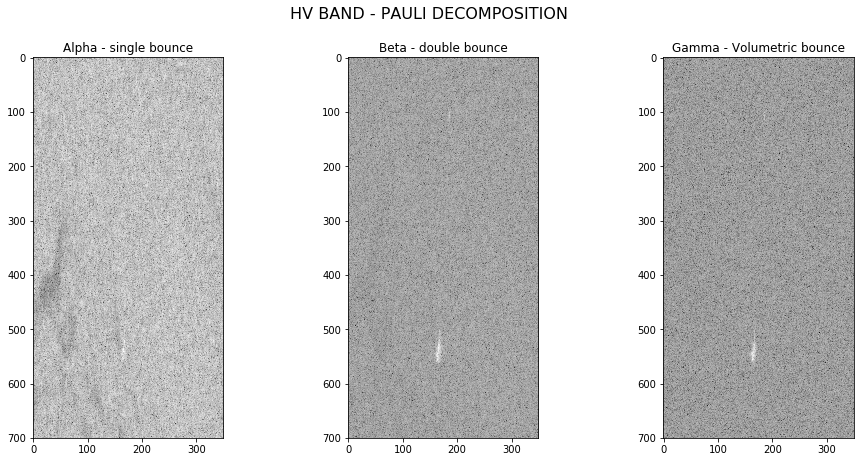

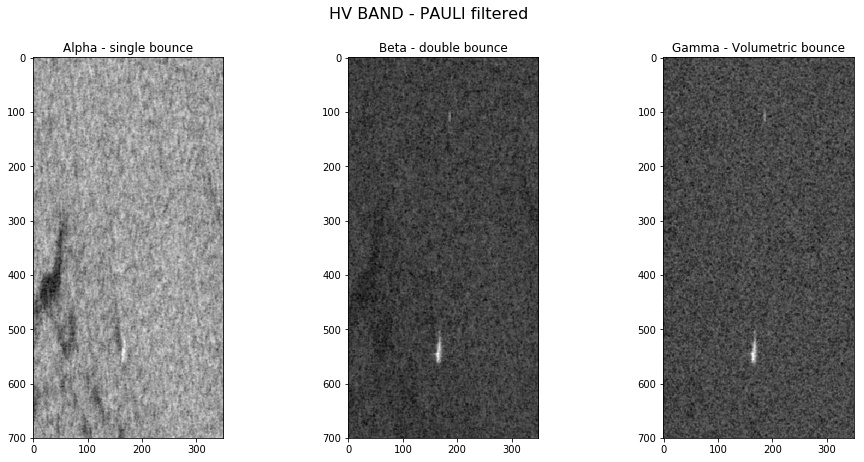

In [42]:
#mostrar as imagens obtidas pela Decomposição de Pauli:
plt.figure( figsize=(16, 7 ))

plt.suptitle("HV BAND - PAULI DECOMPOSITION", fontsize = 16)

plt.subplot(131)
plt.imshow(single_bounce, cmap='gray')
plt.title("Alpha - single bounce")

plt.subplot(132)
plt.imshow(double_bounce, cmap='gray')
plt.title("Beta - double bounce")

plt.subplot(133)
plt.imshow(volumetric_bounce, cmap='gray')
plt.title("Gamma - Volumetric bounce")

plt.show()

plt.figure( figsize=(16, 7 ))
plt.suptitle("HV BAND - PAULI Mean filter", fontsize = 16)

plt.subplot(131)
plt.imshow(sb_mean, cmap='gray')
plt.title("Alpha - single bounce")

plt.subplot(132)
plt.imshow(double_mean, cmap='gray')
plt.title("Beta - double bounce")

plt.subplot(133)
plt.imshow(vol_mean, cmap='gray')
plt.title("Gamma - Volumetric bounce")

plt.show()

## <span style="color:#336699"> __Quarta fase__: Aplicar um limiar para separar os alvos.

__Desafio__: utilizar um threshold adaptativo e criar uma máscara.

<hr style="border:0.5px solid #0077b9;">


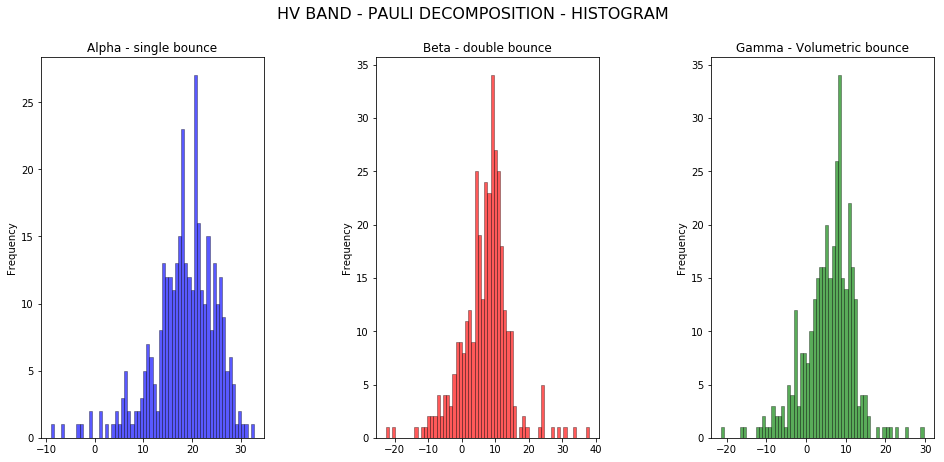

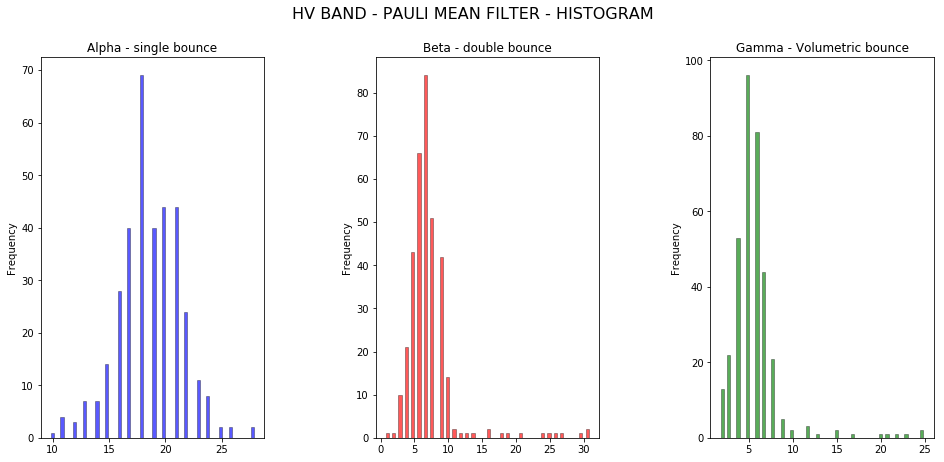

In [45]:
#Plotar os histogramas da linha 545 das imagens decompostas:
plt.figure( figsize=(16, 7) )
plt.suptitle("HV BAND - PAULI DECOMPOSITION - HISTOGRAM", fontsize = 16)
plt.subplots_adjust(wspace=0.5)

plt.subplot(131)
histogram_sar(single_bounce, line=545, facecolor="blue")
plt.title("Alpha - single bounce")

plt.subplot(132)
histogram_sar(double_bounce, line=545)
plt.title("Beta - double bounce")

plt.subplot(133)
histogram_sar(volumetric_bounce, line=545, facecolor="green")
plt.title("Gamma - Volumetric bounce")


plt.figure( figsize=(16, 7) )
plt.suptitle("HV BAND - PAULI MEAN FILTER - HISTOGRAM", fontsize = 16)
plt.subplots_adjust(wspace=0.5)

plt.subplot(131)
histogram_sar(sb_mean, line=545, facecolor="blue")
plt.title("Alpha - single bounce")

plt.subplot(132)
histogram_sar(double_mean, line=545)
plt.title("Beta - double bounce")

plt.subplot(133)
histogram_sar(vol_mean, line=545, facecolor="green")
plt.title("Gamma - Volumetric bounce");

In [64]:
#Aplicando o limiar para imagens filtradas e não filtradas:
threshold1 = (double_bounce >= 30)
threshold2 = (volumetric_bounce >= 25)
threshold3 = (((threshold1) + (threshold2)) > 0)
threshold3_coordinates= np.transpose(np.nonzero(threshold3))

print("As primeiras cinco coordenadas onde foi detectado algum alvo:", '\n', threshold3_coordinates[0:5])

ts_filt_1 = (double_mean >= 15)
ts_filt_2 = (vol_mean >= 11)
ts_filt_3 = (((ts_filt_1) + (ts_filt_2)) > 0)
ts_filt_3_coordinates= np.transpose(np.nonzero(ts_filt_3))

As primeiras cinco coordenadas onde foi detectado algum alvo: 
 [[522 168]
 [524 166]
 [527 165]
 [528 165]
 [528 166]]


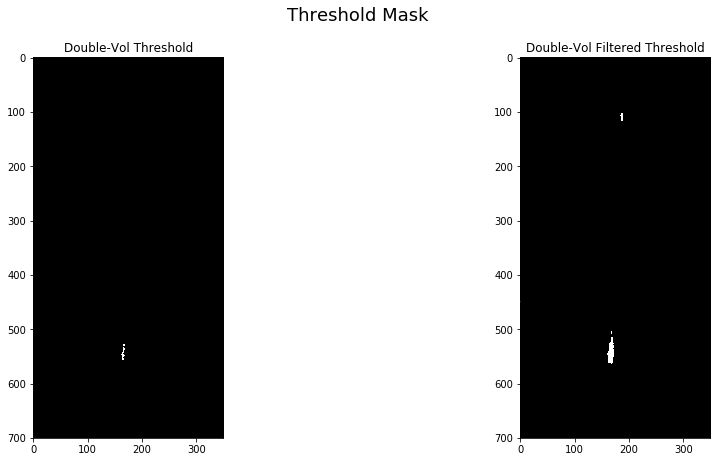

In [65]:
#mostrar as máscaras com e sem filtro:
plt.figure( figsize=(16, 7 ))
plt.suptitle("Threshold Mask",  fontsize=18)

plt.subplot(121)
plt.imshow(threshold3, cmap='gray')
plt.title("Double-Vol Threshold")

plt.subplot(122)
plt.imshow(ts_filt_3, cmap='gray')
plt.title("Double-Vol Filtered Threshold")

plt.show()

In [56]:
# Função para apresentar a imagem 3D:
def TridimHotmap(img, title=None):
    # Montando a superfície da imagem
    heigth, width  = img.shape
    H = np.arange(0,heigth,1,dtype=int)
    W = np.arange(0,width,1,dtype=int)
    Y, X = np.meshgrid(H, W)
    Z = img[heigth-1-Y,X]

    colortuple = ()
    colors = np.empty(X.shape, dtype=str)

    # Cria a figura
    fig = plt.figure(figsize=(5.,5.))
    ax = fig.gca(projection='3d')

    # Define a vista da imagem
    ax.azim = -70
    ax.elev = 30

    # Plota a superfície da imagem
    surf = ax.plot_surface(X,Y,Z,cmap='hot')
    plt.title(title, fontsize=20)
    plt.show()


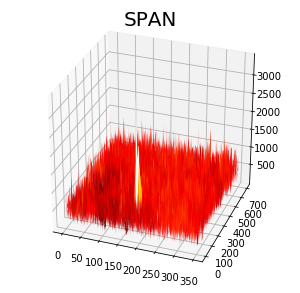

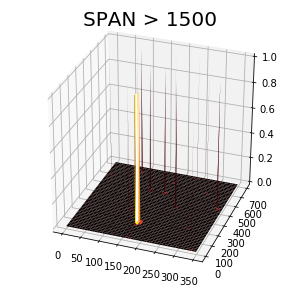

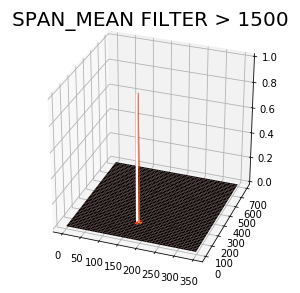

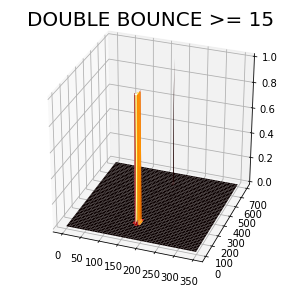

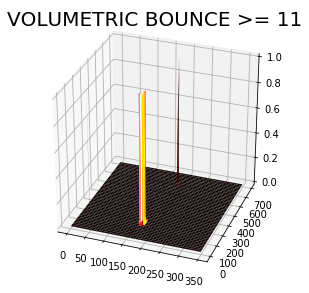

In [66]:
# SPAN 3D filtrado e não filtrado
span = double_bounce**2 + single_bounce**2 + volumetric_bounce**2
span_mean = double_mean**2 + sb_mean**2 + vol_mean**2
fatiamento = span>1500
fatiamento_mean = span_mean>1500
fatiamento_double = double_mean>=15 
fatiamento_vol = vol_mean>=11

TridimHotmap(span , "SPAN")

TridimHotmap(fatiamento, "SPAN > 1500")
TridimHotmap(fatiamento_mean , "SPAN_MEAN FILTER > 1500")
TridimHotmap(fatiamento_double , "DOUBLE BOUNCE >= 15")
TridimHotmap(fatiamento_vol , "VOLUMETRIC BOUNCE >= 11")



<hr style="border:1px solid #0077b9;">

## <span style="color:#336699"> __Conclusão__



<hr style="border:0.5px solid #0077b9;">

### Abaixo a comparação entre os níveis de processamento da imagem, demonstrando como o processamento da imagem SAR pode ser útil para extração de informações. Nesse exemplo, verificação de objetos artificiais no mar.

#### Verdade de campo: Plataforma de Petróleo Merluza
![alt text](http://www.blogdokennedy.com.br/wp-content/uploads/2013/10/okhj.jpg)
![alt text](https://media.gettyimages.com/photos/busy-oil-field-picture-id160808906?k=6&m=160808906&s=170667a&w=0&h=30KKjOfPMtNhwGF0SwgjnTg5bDFrcgo3En5zbwVqV4U=)


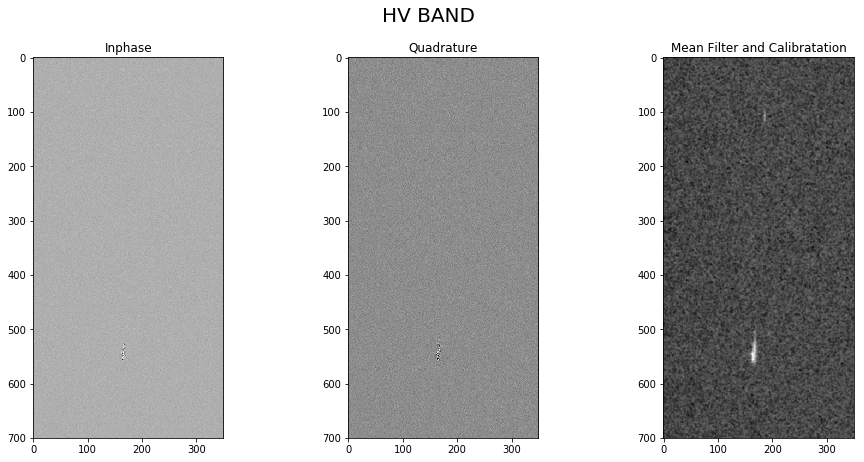

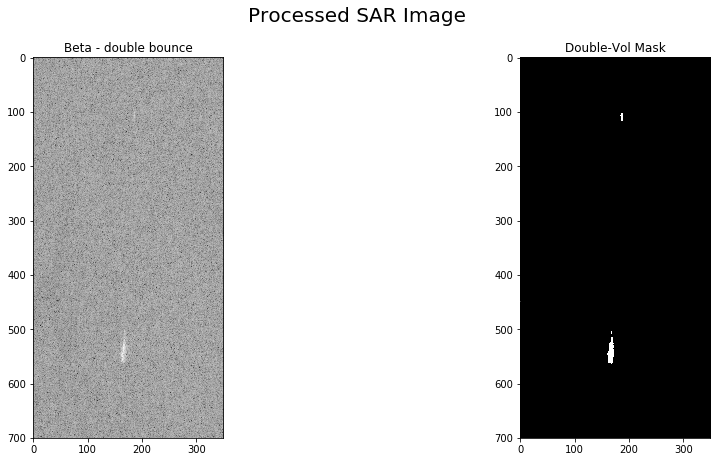

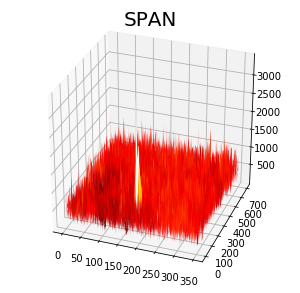

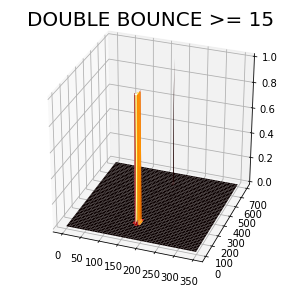

In [67]:
# Mostrar resultados para comparação:

Inphase, Quadrature = InPhaseAndQuadrature(subset_HV)

plt.figure( figsize=(16, 7) )
plt.suptitle("HV BAND", fontsize = 20)

plt.subplot(131)
plt.imshow(Inphase, cmap='gray')
plt.title("Inphase")

plt.subplot(132)
plt.imshow(Quadrature, cmap='gray')
plt.title("Quadrature")

plt.subplot(133)
plt.imshow(subsetHV_SigmaMean, cmap='gray')
plt.title("Mean Filter and Calibratation")

plt.figure( figsize=(16, 7) )
plt.suptitle("Processed SAR Image", fontsize = 20)          

plt.subplot(121)
plt.imshow(double_bounce, cmap='gray')
plt.title("Beta - double bounce")
          
plt.subplot(122)
plt.imshow(ts_filt_3, cmap='gray')
plt.title("Double-Vol Mask")

plt.show()

TridimHotmap(span , "SPAN")
TridimHotmap(fatiamento_double , "DOUBLE BOUNCE >= 15")

<hr style="border:1px solid #0077b9;">

## <span style="color:#336699"> __Referências__

<hr style="border:0.5px solid #0077b9;">

Sobre ALOS/PALSAR:

[1] http://www.eorc.jaxa.jp/ALOS/en/about/palsar.htm

[2] http://www.eorc.jaxa.jp/ALOS/en/doc/fdata/PALSAR_x_Format_EL.pdf

Sobre o driver JAXAPALSAR:

[3] http://www.gdal.org/frmt_palsar.html

Sobre a calibração:

[4] http://www.eorc.jaxa.jp/en/hatoyama/satellite/data_tekyo_setsumei/alos_hyouka_e.html

[5] https://earth.esa.int/documents/700255/709910/Calibration_palsar_products_v13.pdf/b9e33484-3c42-42b4-bbcd-8e224862a8cd?version=1.0

Os códigos de filtragem foram adaptados de:

[6] https://github.com/PyRadar/pyradar

Sobre a decomposição de Pauli:

[7] https://earth.esa.int/documents/653194/656796/Polarimetric_Decompositions.pdf

Sobre Plotagem 3D:

[8] http://www.stt.eesc.usp.br/andre/palestras/CEFET-MG/02_Pratica_imagem.html


